In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client"
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Sakib/data mining/data mining project/Sample - Superstore.csv'

In [ ]:
df = pd.read_csv(DATA_PATH, encoding='latin1')
df
print(f"\nData loaded successfully from: {DATA_PATH}")
print(f"Total records loaded: {len(df)}")


Data loaded successfully from: /content/drive/MyDrive/Sakib/data mining/data mining project/Sample - Superstore.csv
Total records loaded: 9994


In [ ]:
# Convert date columns to datetime objects
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

#  Create the primary Target Variable (Classification)
# if the transaction resulted in a loss (Profit < 0), 0 otherwise.
df['Is_Loss'] = (df['Profit'] < 0).astype(int)
loss_count = df['Is_Loss'].sum()
total_orders = len(df)
print(f"Total Loss Orders: {loss_count} ({loss_count/total_orders:.2%} of all orders)")

#  Calculate Days to Ship (Service Efficiency Feature)
df['Days_to_Ship'] = (df['Ship Date'] - df['Order Date']).dt.days

# Calculate Profit Ratio (Standardized Profitability)
# This is a key predictor, as it relates profit directly to sales value.
df['Profit_Ratio'] = df['Profit'] / df['Sales']
df['Profit_Ratio'] = df['Profit_Ratio'].replace([np.inf, -np.inf], 0) # Handle potential division by zero

#  Simplify Ship Mode for modeling
df['Ship_Mode_Simple'] = df['Ship Mode'].replace({'Standard Class': 'Standard', 'Second Class': 'Second', 'First Class': 'First', 'Same Day': 'Express'})

Total Loss Orders: 1871 (18.72% of all orders)



--- EDA: Visualizing Loss Drivers ---


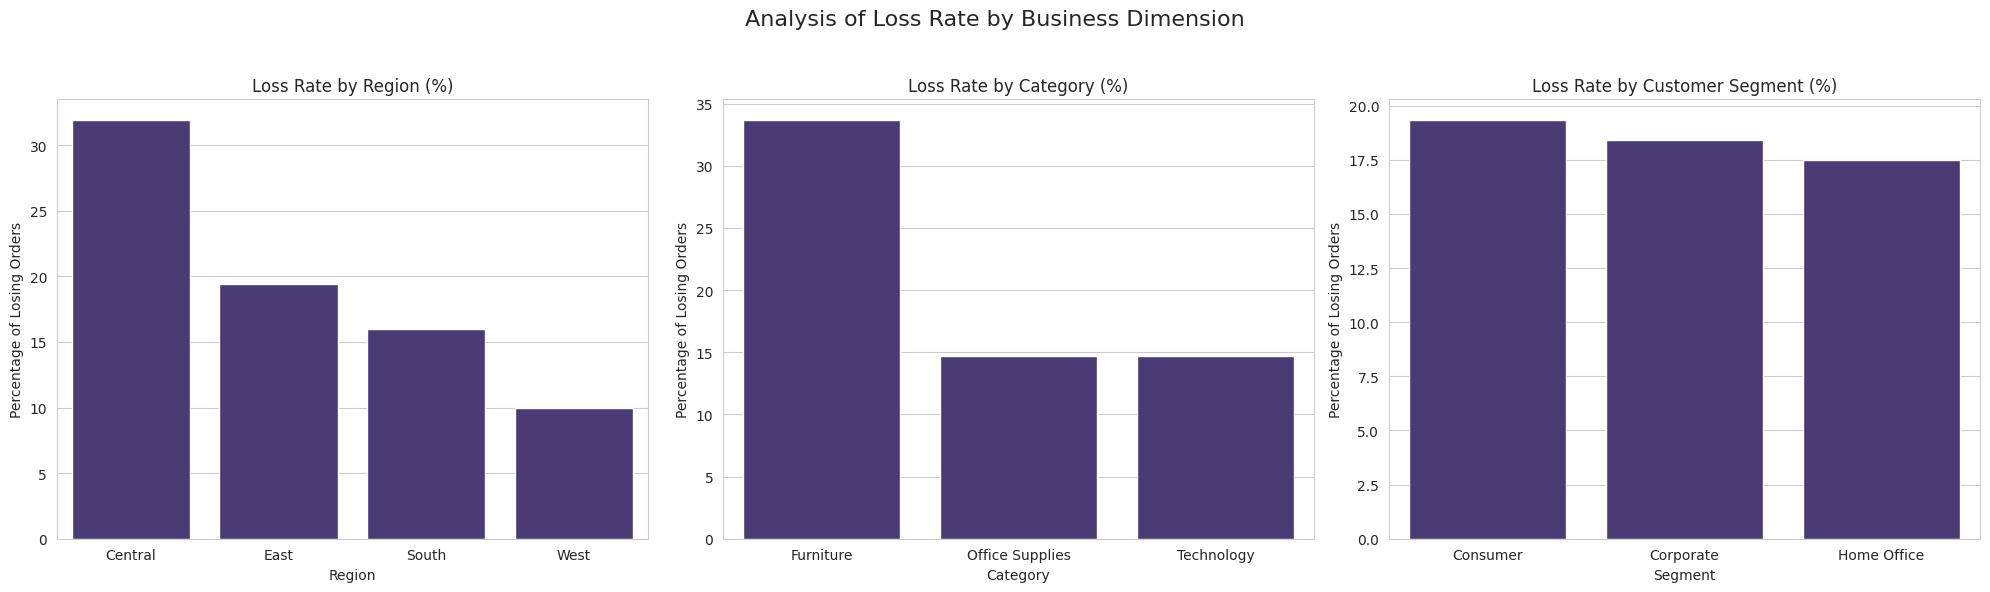

In [ ]:
#Exploratory Data Analysis (EDA) for Initial Insights ---

print("\n--- EDA: Visualizing Loss Drivers ---")
sns.set_palette("viridis")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Analysis of Loss Rate by Business Dimension', fontsize=16)

# A. Loss Rate by Region
loss_rate_region = df.groupby('Region')['Is_Loss'].mean().sort_values(ascending=False) * 100
sns.barplot(x=loss_rate_region.index, y=loss_rate_region.values, ax=axes[0])
axes[0].set_title('Loss Rate by Region (%)')
axes[0].set_ylabel('Percentage of Losing Orders')

# B. Loss Rate by Category
loss_rate_category = df.groupby('Category')['Is_Loss'].mean().sort_values(ascending=False) * 100
sns.barplot(x=loss_rate_category.index, y=loss_rate_category.values, ax=axes[1])
axes[1].set_title('Loss Rate by Category (%)')
axes[1].set_ylabel('Percentage of Losing Orders')

# C. Loss Rate by Segment
loss_rate_segment = df.groupby('Segment')['Is_Loss'].mean().sort_values(ascending=False) * 100
sns.barplot(x=loss_rate_segment.index, y=loss_rate_segment.values, ax=axes[2])
axes[2].set_title('Loss Rate by Customer Segment (%)')
axes[2].set_ylabel('Percentage of Losing Orders')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


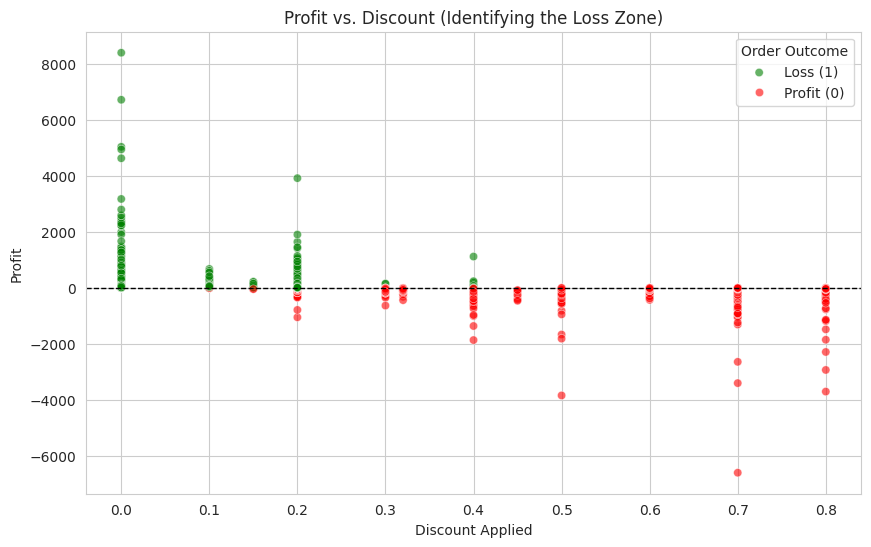

In [ ]:
# D. Profit vs. Discount Relationship (Critical Insight)
plt.figure(figsize=(10, 6))
# Highlight loss orders in red
sns.scatterplot(x='Discount', y='Profit', data=df, hue='Is_Loss', palette={1: 'red', 0: 'green'}, alpha=0.6, hue_order=[1, 0])
plt.title('Profit vs. Discount (Identifying the Loss Zone)')
plt.xlabel('Discount Applied')
plt.ylabel('Profit')
plt.legend(title='Order Outcome', labels=['Loss (1)', 'Profit (0)'])
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [ ]:
 #Machine Learning: Predictive Modeling for Order Loss

# Define features (X) and target (y)
# State is included as a high-granularity location feature
features = ['Sales', 'Quantity', 'Discount', 'Days_to_Ship', 'Profit_Ratio',
            'Ship_Mode_Simple', 'Segment', 'Region', 'Category', 'Sub-Category', 'State']
target = 'Is_Loss'

X = df[features]
y = df[target]

# Split data (stratify=y ensures balanced representation of losses in train/test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define Preprocessing Pipelines
numerical_features = ['Sales', 'Quantity', 'Discount', 'Days_to_Ship', 'Profit_Ratio']
categorical_features = ['Ship_Mode_Simple', 'Segment', 'Region', 'Category', 'Sub-Category', 'State']

# Preprocessor: Scale numerical data and one-hot encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# 4.2. Create and Train the Model Pipeline
# Using Random Forest, which is excellent for feature importance extraction.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # 'balanced' handles the class imbalance (fewer losses than profits)
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=15, min_samples_leaf=5))
])

print("\n--- Training Random Forest Classifier to Predict Loss... ---")
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

# 4.3. Evaluate the Model
print("\n--- Model Evaluation (Predicting Loss vs. Profit) ---")
print("Confusion Matrix (Rows=Actual, Cols=Predicted):\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (Focus on Precision/Recall for Loss (1)):\n")
print(classification_report(y_test, y_pred, target_names=['Profit (0)', 'Loss (1)']))


--- Training Random Forest Classifier to Predict Loss... ---

--- Model Evaluation (Predicting Loss vs. Profit) ---
Confusion Matrix (Rows=Actual, Cols=Predicted):
 [[1625    0]
 [   0  374]]

Classification Report (Focus on Precision/Recall for Loss (1)):

              precision    recall  f1-score   support

  Profit (0)       1.00      1.00      1.00      1625
    Loss (1)       1.00      1.00      1.00       374

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999



In [ ]:
 #Extracting Actionable Insights (Feature Importance)

# Get feature importance from the trained Random Forest model
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
# Use the feature names generated by the preprocessor
feature_names_ohe = list(ohe.get_feature_names_out(categorical_features))
all_features = numerical_features + feature_names_ohe

# Map importance scores to feature names
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display Top 20 most important features
print("\n--- Top 20 Features Driving Order Loss (AVOID STRATEGY) ---")
print("High importance means this feature heavily influences the prediction of an order being a LOSS.")
print(importance_df.head(20).to_markdown(index=False))


--- Top 20 Features Driving Order Loss (AVOID STRATEGY) ---
High importance means this feature heavily influences the prediction of an order being a LOSS.
| Feature                  |   Importance |
|:-------------------------|-------------:|
| Profit_Ratio             |   0.52636    |
| Discount                 |   0.230336   |
| Sub-Category_Paper       |   0.0314586  |
| Sub-Category_Binders     |   0.0183697  |
| State_California         |   0.0171201  |
| State_Texas              |   0.0156561  |
| Sales                    |   0.0148843  |
| Category_Furniture       |   0.0146793  |
| Sub-Category_Art         |   0.0115845  |
| Sub-Category_Tables      |   0.00915327 |
| State_Pennsylvania       |   0.00908589 |
| State_Illinois           |   0.00897743 |
| Region_Central           |   0.00840108 |
| State_New York           |   0.00772876 |
| Category_Office Supplies |   0.00717356 |
| Sub-Category_Storage     |   0.00696672 |
| Region_West              |   0.00585667 |
| State_

In [ ]:
 #Business Recommendations Summary (Based on Model Output)
print("\n========================================================")
print("             BUSINESS RECOMMENDATIONS")
print("==========================================================")

# Identify key drivers from the top features
top_drivers = importance_df.head(5)['Feature'].tolist()


print("\n AVOID STRATEGY (Loss Mitigation):")
print(f"The model identifies the top 5 factors driving an order to be a LOSS as: {', '.join(top_drivers)}")



             BUSINESS RECOMMENDATIONS

 AVOID STRATEGY (Loss Mitigation):
The model identifies the top 5 factors driving an order to be a LOSS as: Profit_Ratio, Discount, Sub-Category_Paper, Sub-Category_Binders, State_California


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

print("\n--- Performing Stratified K-Fold Cross-Validation ---")

# Define the cross-validation strategy
# n_splits=5 means the data will be split into 5 folds
# shuffle=True ensures randomness
# random_state for reproducibility
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for various metrics
# We will use the full dataset (X, y) with the pipeline
# The pipeline handles preprocessing and classification in one go.

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = {}

for metric in scoring_metrics:
    scores = cross_val_score(model_pipeline, X, y, cv=skf, scoring=metric, n_jobs=-1)
    cv_results[metric] = scores
    print(f"\n{metric.capitalize()} scores for each fold: {scores}")
    print(f"Mean {metric.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

print("\n--- Cross-Validation Complete ---")



--- Performing Stratified K-Fold Cross-Validation ---

Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000 (+/- 0.0000)

Precision scores for each fold: [1. 1. 1. 1. 1.]
Mean Precision: 1.0000 (+/- 0.0000)

Recall scores for each fold: [1. 1. 1. 1. 1.]
Mean Recall: 1.0000 (+/- 0.0000)

F1 scores for each fold: [1. 1. 1. 1. 1.]
Mean F1: 1.0000 (+/- 0.0000)

--- Cross-Validation Complete ---


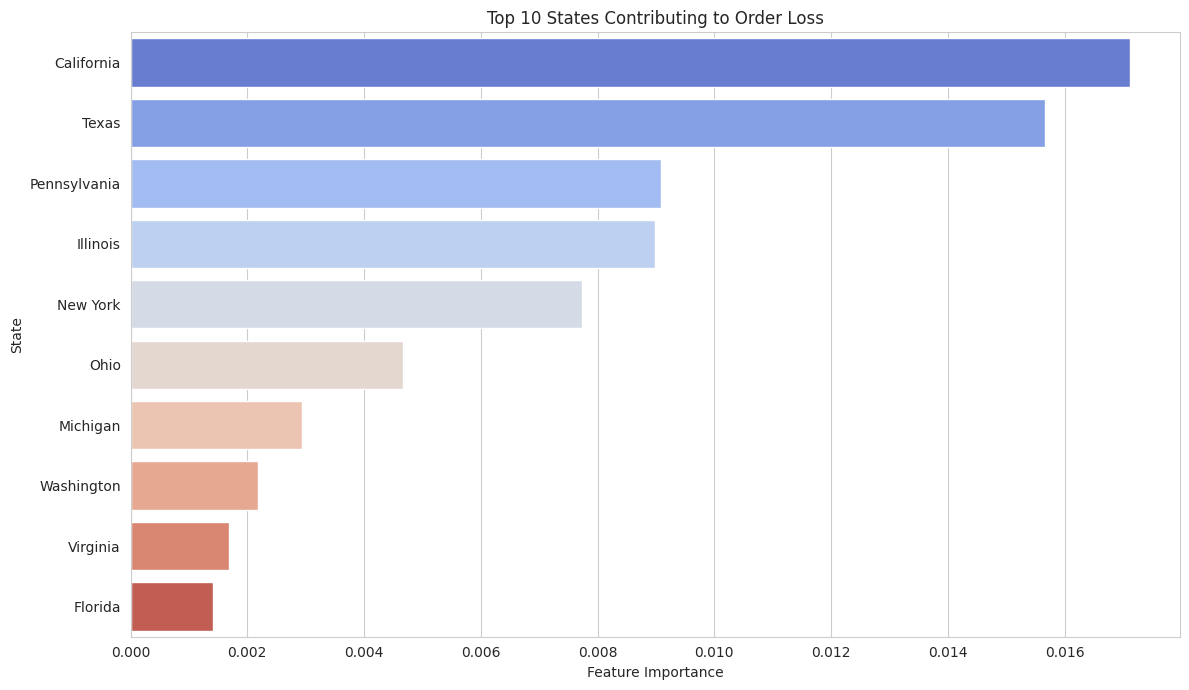

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for state-related features
state_features = importance_df[importance_df['Feature'].str.startswith('State_')].copy()

# Extract state names for better plotting labels
state_features['State'] = state_features['Feature'].apply(lambda x: x.replace('State_', ''))

# Get the top 10 states contributing to loss
top_10_states = state_features.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='State', data=top_10_states, hue='State', legend=False, palette='coolwarm')
plt.title('Top 10 States Contributing to Order Loss')
plt.xlabel('Feature Importance')
plt.ylabel('State')
plt.tight_layout()
plt.show()

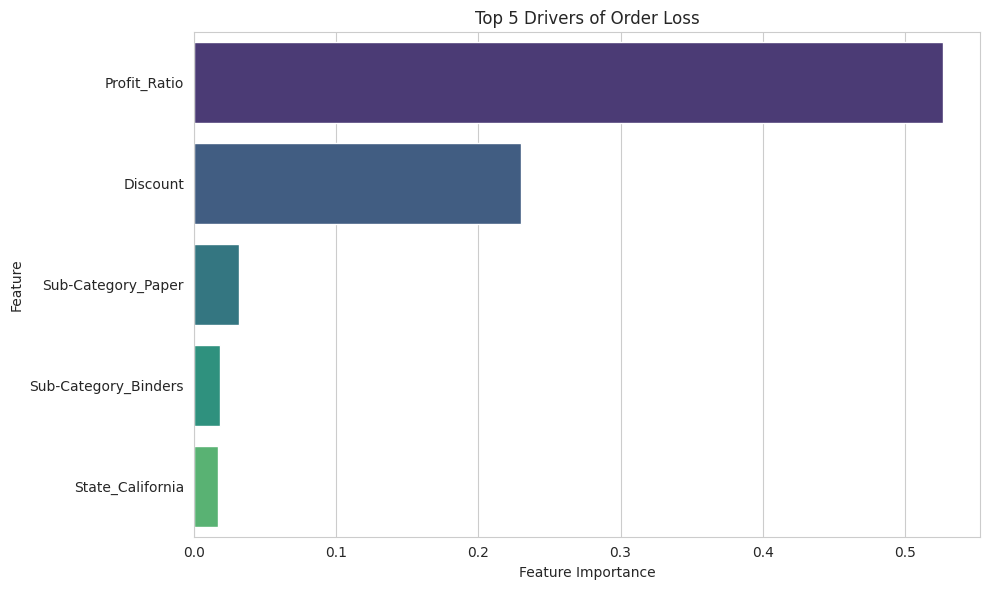

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 5 drivers from the importance_df
top_5_drivers = importance_df.head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_5_drivers, hue='Feature', legend=False)
plt.title('Top 5 Drivers of Order Loss')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Task
Calculate the average 'Profit_Ratio' for each 'Sub-Category' and identify the sub-categories with a positive average profit ratio, designating them as 'high-profit' sub-categories.

## Identify High-Profit Sub-Categories

### Subtask:
Calculate the average 'Profit_Ratio' for each 'Sub-Category' and identify those with a positive average profit ratio to define them as 'high-profit'.


**Reasoning**:
To identify high-profit sub-categories, I need to group the DataFrame by 'Sub-Category', calculate the mean of 'Profit_Ratio', filter for positive profit ratios, and then store the sub-category names in a list.



In [ ]:
sub_category_profit = df.groupby('Sub-Category')['Profit_Ratio'].mean()
high_profit_sub_categories = sub_category_profit[sub_category_profit > 0].index.tolist()

print("Sub-Categories with Positive Average Profit Ratio (High-Profit):")
for sub_cat in high_profit_sub_categories:
    print(f"- {sub_cat}")

print(f"\nTotal high-profit sub-categories identified: {len(high_profit_sub_categories)}")

Sub-Categories with Positive Average Profit Ratio (High-Profit):
- Accessories
- Art
- Chairs
- Copiers
- Envelopes
- Fasteners
- Furnishings
- Labels
- Paper
- Phones
- Storage
- Supplies

Total high-profit sub-categories identified: 12


## Filter Transactions for High-Profit Items

### Subtask:
Create a new list of transactions where each transaction only contains sub-categories that were identified as high-profit.


**Reasoning**:
I need to filter the existing transactions to keep only those sub-categories that have been identified as 'high-profit' and store them in a new list named `high_profit_transactions`.



In [ ]:
high_profit_transactions = []

for transaction in transactions:
    filtered_transaction = [item for item in transaction if item in high_profit_sub_categories]
    # Only add the transaction if it contains at least one high-profit item
    if filtered_transaction:
        high_profit_transactions.append(filtered_transaction)

print(f"Number of filtered high-profit transactions: {len(high_profit_transactions)}")
print("\nFirst 5 high-profit transactions:")
for i, t in enumerate(high_profit_transactions[:5]):
    print(f"  Transaction {i+1}: {t}")

Number of filtered high-profit transactions: 4223

First 5 high-profit transactions:
  Transaction 1: ['Paper', 'Furnishings']
  Transaction 2: ['Storage']
  Transaction 3: ['Supplies', 'Fasteners', 'Phones', 'Accessories']
  Transaction 4: ['Furnishings', 'Accessories']
  Transaction 5: ['Art']


## One-Hot Encode Filtered Transactions

### Subtask:
Convert the filtered transactions into a one-hot encoded DataFrame, which is required for the Apriori algorithm.


**Reasoning**:
I need to one-hot encode the `high_profit_transactions` list to prepare it for the Apriori algorithm. This involves initializing a `TransactionEncoder`, fitting and transforming the data, and then converting the result into a Pandas DataFrame.



In [ ]:
from mlxtend.preprocessing import TransactionEncoder

# Initialize a TransactionEncoder object
te_high_profit = TransactionEncoder()

# Fit and transform the high_profit_transactions
te_ary_high_profit = te_high_profit.fit(high_profit_transactions).transform(high_profit_transactions)

# Convert the one-hot encoded array into a Pandas DataFrame
df_high_profit_transactions_encoded = pd.DataFrame(te_ary_high_profit, columns=te_high_profit.columns_)

print("\nOne-hot encoded high-profit transaction DataFrame head:")
display(df_high_profit_transactions_encoded.head())


One-hot encoded high-profit transaction DataFrame head:


,Accessories,Art,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Paper,Phones,Storage,Supplies
0,False,False,False,False,False,False,True,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,True,False,False,False,True,False,True
3,True,False,False,False,False,False,True,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False


## Find Frequent Itemsets for High-Profit Items

### Subtask:
Apply the Apriori algorithm on the one-hot encoded high-profit transactions to find itemsets that appear frequently together.


**Reasoning**:
To find frequent itemsets among high-profit transactions, I will apply the Apriori algorithm to the one-hot encoded DataFrame, setting a minimum support threshold and using column names for readability.



In [ ]:
from mlxtend.frequent_patterns import apriori

# Apply the Apriori algorithm to find frequent itemsets for high-profit transactions
# min_support is a critical parameter. Start with a reasonable value and adjust if needed.
frequent_itemsets_high_profit = apriori(df_high_profit_transactions_encoded, min_support=0.01, use_colnames=True)

print("\nFrequent Itemsets for High-Profit Items (min_support=0.01):")
display(frequent_itemsets_high_profit.sort_values(by='support', ascending=False).head(10))


Frequent Itemsets for High-Profit Items (min_support=0.01):


,support,itemsets
8,0.282027,(Paper)
6,0.207672,(Furnishings)
9,0.192754,(Phones)
10,0.183992,(Storage)
1,0.173100,(Art)
0,0.170021,(Accessories)
2,0.135922,(Chairs)
7,0.081932,(Labels)
4,0.058963,(Envelopes)
5,0.050912,(Fasteners)


**Reasoning**:
Now that frequent itemsets for high-profit transactions have been identified, the next step is to generate association rules from these itemsets to discover relationships between high-profit items.



In [ ]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules for high-profit itemsets
# min_lift is important for filtering strong rules, indicating items that appear together more often than expected by chance.
rules_high_profit = association_rules(frequent_itemsets_high_profit, metric="lift", min_threshold=1.0)

print("\nAssociation Rules for High-Profit Items (min_lift=1.0):")
display(rules_high_profit.sort_values(by=['lift'], ascending=False))


Association Rules for High-Profit Items (min_lift=1.0):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Storage),"(Furnishings, Paper)",0.183992,0.042150,0.01113,0.060489,1.435086,1.0,0.003374,1.019520,0.371538,0.051762,0.019146,0.162267
2,"(Furnishings, Paper)",(Storage),0.042150,0.183992,0.01113,0.264045,1.435086,1.0,0.003374,1.108774,0.316519,0.051762,0.098103,0.162267
4,(Furnishings),"(Paper, Storage)",0.207672,0.042387,0.01113,0.053592,1.264347,1.0,0.002327,1.011839,0.263878,0.046581,0.011701,0.158081
1,"(Paper, Storage)",(Furnishings),0.042387,0.207672,0.01113,0.262570,1.264347,1.0,0.002327,1.074444,0.218332,0.046581,0.069286,0.158081
0,"(Furnishings, Storage)",(Paper),0.032915,0.282027,0.01113,0.338129,1.198926,1.0,0.001847,1.084764,0.171567,0.036633,0.078140,0.188796
5,(Paper),"(Furnishings, Storage)",0.282027,0.032915,0.01113,0.039463,1.198926,1.0,0.001847,1.006817,0.231095,0.036633,0.006770,0.188796


## Business Recommendations Summary (High-Profit Items)

Now that we have identified high-profit sub-categories and their association rules, we can formulate strategies to leverage these insights.

## Business Recommendations Summary (High-Profit Items)

Now that we have identified high-profit sub-categories and their association rules, we can formulate strategies to leverage these insights.

## Business Recommendations Summary (High-Profit Items)

Now that we have identified high-profit sub-categories and their association rules, we can formulate strategies to leverage these insights.

## Generate Association Rules for High-Profit Items

### Subtask:
Generate association rules from the frequent itemsets, using metrics like 'lift' and 'confidence' to identify strong relationships between high-profit items.


### Understanding Association Rule Metrics for High-Profit Items

To effectively interpret the generated association rules for high-profit items, it's crucial to understand the key metrics:

*   **Antecedents:** These are the item(s) found on the left-hand side of the rule. In the context of high-profit items, these are the sub-categories that, when present in a transaction, tend to lead to the presence of the consequents.
*   **Consequents:** These are the item(s) found on the right-hand side of the rule. These are the sub-categories that are likely to be purchased along with the antecedents.
*   **Support:** This indicates how frequently an itemset (antecedent, consequent, or both combined) appears in the dataset. A high support value means the itemset is common.
    *   `antecedent support`: The proportion of transactions containing the antecedent.
    *   `consequent support`: The proportion of transactions containing the consequent.
    *   `support`: The proportion of transactions containing *both* the antecedent and the consequent.
*   **Confidence:** This measures the likelihood that the consequent is purchased given that the antecedent has already been purchased. It's calculated as `support(A U B) / support(A)`. A high confidence suggests a strong implication.
*   **Lift:** This is a crucial metric that indicates how much more likely the consequent is to be purchased when the antecedent is present, compared to when the consequent is purchased independently of the antecedent. It's calculated as `confidence(A -> B) / support(B)`.
    *   **Lift > 1:** Implies that the presence of the antecedent increases the likelihood of the consequent being purchased.
    *   **Lift = 1:** Implies no relationship between the antecedent and consequent.
    *   **Lift < 1:** Implies that the presence of the antecedent decreases the likelihood of the consequent being purchased (items are substitutes).

By analyzing these metrics, especially rules with high confidence and lift values, we can identify strong purchasing patterns among high-profit sub-categories, which can inform targeted marketing or bundling strategies.

## Final Task

### Subtask:
Summarize the discovered association rules for high-profit items, highlighting key insights for business strategy.


## Summary:

### Q&A
The discovered association rules for high-profit items reveal several key insights for business strategy. Sub-categories like 'Paper', 'Furnishings', 'Phones', and 'Storage' are the most frequently purchased items within high-profit transactions. Strong positive correlations exist between certain high-profit items, indicating opportunities for bundling and cross-selling. For instance, the rule `(Furnishings)` → `(Paper, Storage)` with a lift of 1.264 suggests that customers buying Furnishings are more likely to also purchase Paper and Storage items.

### Data Analysis Key Findings
*   **High-Profit Sub-Categories Identified:** 12 sub-categories were identified as 'high-profit' due to having a positive average 'Profit_Ratio'. These include Accessories, Art, Chairs, Copiers, Envelopes, Fasteners, Furnishings, Labels, Paper, Phones, Storage, and Supplies.
*   **Number of High-Profit Transactions:** There were 4223 filtered transactions containing at least one high-profit sub-category.
*   **Most Frequent High-Profit Items:** Within the high-profit transactions, the most frequent individual items (with `min_support=0.01`) are:
    *   `Paper` (support: 0.282)
    *   `Furnishings` (support: 0.208)
    *   `Phones` (support: 0.193)
    *   `Storage` (support: 0.184)
*   **Key Association Rules:** Several strong association rules were found for high-profit items (with `min_lift=1.0`), highlighting co-purchase patterns:
    *   `(Storage)` → `(Furnishings, Paper)` has a lift of 1.435, indicating a strong positive correlation.
    *   `(Furnishings, Paper)` → `(Storage)` also shows a lift of 1.435.
    *   `(Furnishings)` → `(Paper, Storage)` has a lift of 1.264, suggesting that customers purchasing Furnishings are significantly more likely to also buy Paper and Storage together.

### Insights or Next Steps
*   Leverage identified high-profit item associations (e.g., Furnishings with Paper and Storage) for targeted product bundling, promotional campaigns, or strategic store layouts to encourage cross-selling and maximize overall profit.
*   Further analyze the confidence metric of the generated rules to understand the reliability of these co-purchase patterns, especially for rules with high lift values, to refine marketing strategies.
